# Structured hierarchical linear models

This project proposes a family of models, the *structured hierarchical linear model*, in order to incorporate biological prior knowledge into probabilistic models. The models can be easily described as:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2_g & \sim \text{Inverse-Gamma}(2, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2_{z_g}) \\
\mathbf{y} \mid \boldsymbol \gamma & \sim \text{HM}(\mathbf{y} \mid \gamma)\\
\end{align}

The MRF is encoded as Potts-model. The HM can either be linear (this notebook) or nonlinear ([this notebook](./01b-hierarchical_nonlinear_model.ipynb)).

## SHMs for inferring pan-cellline essential genes

We apply our model to infer essential pan-cellline genes from CRISPR genes:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2_g & \sim \text{Inverse-Gamma}(2, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2_{z_g}) \\
\tau^2_c & \sim \text{Inverse-Gamma}(2, 1) \\
\beta_{gc} \mid \gamma_g & \sim \mathcal{N}(\gamma_g, \tau_c^2) \\
l_{s} & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Half-Cauchy}(0, 3)\\
x_{gcs} \mid \beta_{cg}, l_s & \sim \mathcal{N}\left(l_{s} + o_s \cdot \beta_{cg}, \sigma^2 \right) \\
\end{align}

where we use $l_s$ as sgRNA correction factor and $o_s$ to model its binding affinity. Noise is expected to me homoscedastic. We compare the model against a model that does not have the clustering in the latent space and one that has a classical clustering model on the latent space.

In [1]:
import shm
import numpy
import networkx
import matplotlib
import seaborn as sns
import pandas as pd
import pickle
import pymc3 as pm

In [2]:
import arviz as az
import shm.plot as sp
import matplotlib.pyplot as plt
import seaborn as sns
from shm.models.hlm import HLM

In [3]:
import os

In [4]:
from pymc3 import model_to_graphviz

In [5]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 3)

Populating the interactive namespace from numpy and matplotlib


In [6]:
sns.set_style(
  "white",
  {
      "xtick.bottom": True,
      "ytick.left": True,
      "axes.spines.top": False,
      "axes.spines.right": False,
  },
)

In [7]:
def read_graph(infile):
    with open(infile, "rb") as fh:
        G = pickle.load(fh)
    return G

# Model evaluation

In [12]:
readout_file = "../data_raw/simulated_data.tsv"
graph_file = "../data_raw/graph.pickle"
data_file = "../data_raw/data.pickle"

In [27]:
with open(data_file, "rb") as fh:    
    data = pickle.load(fh)

In [25]:
readout = pd.read_csv(readout_file, sep="\t")
G = read_graph(graph_file)

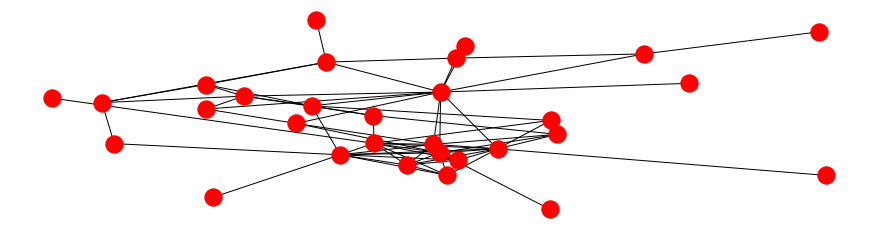

In [28]:
networkx.draw(data["graph"], node_color="red")

## Simple model

In [13]:
trace_dir = "../../../results/simple_model_trace"
with HLM(readout, model="simple") as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building simple hierarchical model
100%|██████████| 10000/10000 [00:10<00:00, 931.98it/s]


In [27]:
data['gamma']

array([-0.83756546, -1.06117564, -1.05281718, -1.10729686, -0.91345924,
       -1.23015387, -0.82551882, -1.07612069, -0.96809609, -0.02493704,
        0.14621079, -0.20601407, -0.03224172, -0.03840544,  0.11337694,
       -0.10998913, -0.01724282, -0.08778584,  0.00422137,  0.05828152])

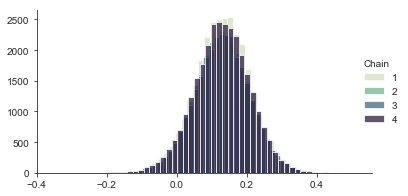

In [31]:
sp.plot_hist(trace, "gamma", 0, "");

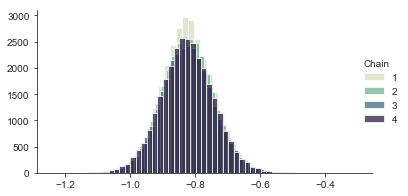

In [32]:
sp.plot_hist(trace, "gamma", 15, "");

In [14]:
trace

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -0.02493704,
        0.14621079, -0.20601407, -0.03224172, -0.03840544,  0.11337694,
       -0.10998913, -0.01724282, -0.08778584,  0.00422137,  0.05828152,
       -0.11006192,  0.11447237,  0.09015907,  0.05024943,  0.09008559,
       -0.06837279, -0.01228902, -0.09357694, -0.02678881,  0.05303555,
       -0.06916608, -0.03967535, -0.06871727, -0.08452056, -0.06712461,
       -0.00126646, -0.11173103,  0.02344157,  0.16598022])

In [36]:
data['gamma']

array([-0.83756546, -1.06117564, -1.05281718, -1.10729686, -0.91345924,
       -1.23015387, -0.82551882, -1.07612069, -0.96809609, -0.02493704,
        0.14621079, -0.20601407, -0.03224172, -0.03840544,  0.11337694,
       -0.10998913, -0.01724282, -0.08778584,  0.00422137,  0.05828152])

In [35]:
numpy.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())]

array([-0.82518296, -1.07541764, -1.00491074, -1.02941005, -0.9593835 ,
       -1.08668379, -0.68708683, -1.13211931, -0.87323455, -0.09774566,
        0.1285659 , -0.26310122, -0.09672012, -0.02028132,  0.1338537 ,
       -0.10352475,  0.04524915, -0.1322112 ,  0.00409337,  0.02397476])

In [60]:
data['beta']

array([-0.11006192,  0.11447237,  0.09015907,  0.05024943,  0.09008559,
       -0.06837279, -0.01228902, -0.09357694, -0.02678881,  0.05303555,
       -0.06916608, -0.03967535, -0.06871727, -0.08452056, -0.06712461,
       -0.00126646, -0.11173103,  0.02344157,  0.16598022,  0.07420442,
       -0.01918356, -0.0887629 , -0.07471583,  0.16924546,  0.00508078,
       -0.06369956,  0.01909155,  0.21002551,  0.0120159 ,  0.06172031,
        0.03001703, -0.03522498, -0.11425182, -0.03493427, -0.02088942,
        0.05866232,  0.08389834,  0.09311021,  0.02855873,  0.08851412])

In [62]:
numpy.mean(trace['beta'], 0)[list(model._beta_idx_to_gene_cond.keys())]

array([ 0.05719604, -0.02111052,  0.05069264, -0.08140155, -0.0253869 ,
        0.01299076, -0.12363053,  0.10523419,  0.04367733, -0.04316118,
        0.05700101, -0.09062025, -0.04222987,  0.10560368, -0.06414112,
        0.0186227 ,  0.006769  ,  0.0160735 , -0.00822439, -0.01301625,
       -0.07899744,  0.13661178, -0.04596589, -0.02614349,  0.03978786,
       -0.06067266,  0.07082861, -0.06559684, -0.00821378,  0.06876073,
       -0.05275385,  0.0304792 ,  0.04117282, -0.01297141, -0.04653484,
        0.01325583, -0.05478962,  0.06902554, -0.03557248,  0.05681661])

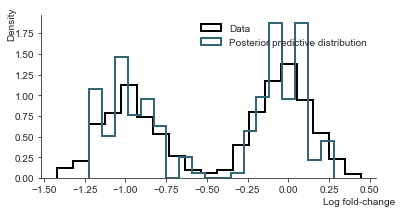

In [46]:
sp.plot_steps(readout, ppc_trace, bins=19);

In [63]:
data['essential_genes']

array(['PSMC5', 'PSMB1', 'PSMC3', 'POLR3K', 'POLR2C', 'POLR1B', 'PSMC1',
       'PSMD4', 'TH'], dtype='<U9')

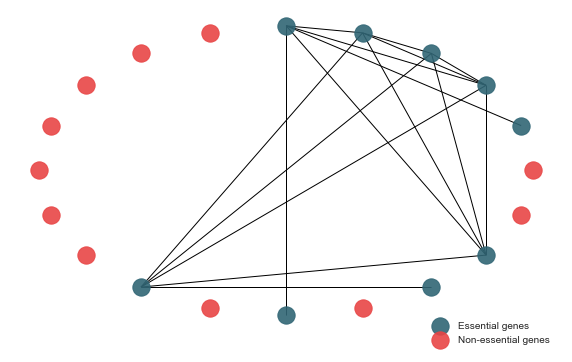

In [70]:
plt.figure(figsize=(10, 6))
pos = networkx.shell_layout(G)
networkx.draw_networkx_nodes(
  G, pos=pos,
  nodelist=list(data['essential_genes']), node_size=300,
  node_color='#316675', font_size=15, alpha=.9, label="Essential genes")
networkx.draw_networkx_nodes(
  G, pos=pos,
  nodelist=list(data['nonessential_genes']), node_size=300,
  node_color='#E84646', font_size=15, alpha=.9, label="Non-essential genes")
networkx.draw_networkx_edges(G, pos=pos)
plt.axis('off')
plt.legend(loc='center right', fancybox=False, framealpha=0, shadow=False,
           borderpad=1, bbox_to_anchor=(1, 0), ncol=1)

## Clustering model

In [40]:
trace_dir = "../../../results/clustering_model_trace"
with HLM(readout, model="clustering") as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building cluster hierarchical model


KeyboardInterrupt: 

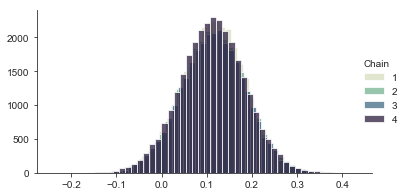

In [49]:
sp.plot_hist(trace, "gamma", 0, "");

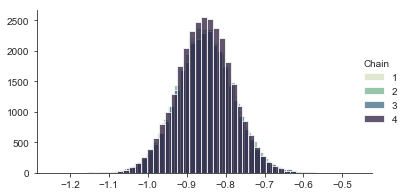

In [50]:
sp.plot_hist(trace, "gamma", 15, "");

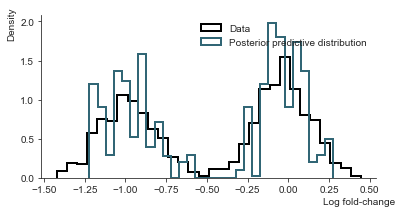

In [54]:
sp.plot_steps(readout, ppc_trace, bins=30);

In [51]:
numpy.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())]

array([-0.85424724, -1.07629864, -1.01332676, -1.03509804, -0.97379089,
       -1.08585641, -0.72632995, -1.12670905, -0.89693853, -0.07721574,
        0.1136477 , -0.22014562, -0.07630356, -0.01111495,  0.11757668,
       -0.08227622,  0.04374683, -0.10594574,  0.00847529,  0.02512337])

In [53]:
data['gamma']

array([-0.83756546, -1.06117564, -1.05281718, -1.10729686, -0.91345924,
       -1.23015387, -0.82551882, -1.07612069, -0.96809609, -0.02493704,
        0.14621079, -0.20601407, -0.03224172, -0.03840544,  0.11337694,
       -0.10998913, -0.01724282, -0.08778584,  0.00422137,  0.05828152])

In [39]:
data['essential_genes']

array(['PSMC5', 'PSMB1', 'PSMC3', 'POLR3K', 'POLR2C', 'POLR1B', 'PSMC1',
       'PSMD4', 'TH'], dtype='<U9')

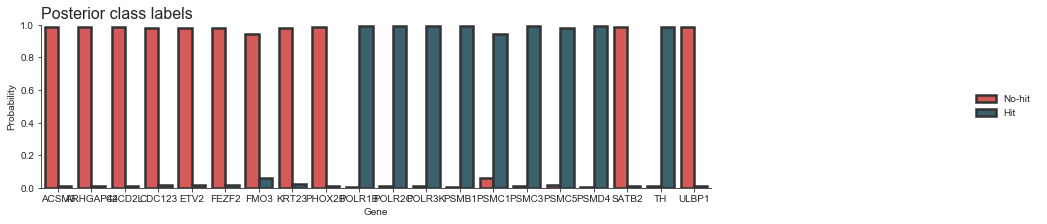

In [38]:
sp.plot_posterior_labels(
    trace, 
    [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]);

In [59]:
np.mean((readout["readout"].values - np.mean(ppc_trace['x'], 0))**2)

8.351945972340868

## MRF model

In [16]:
trace_dir = "../../../results/mrf_model_trace"
trace_dir = "../../../results/test-mrf_model_trace"
with HLM(readout, model="mrf", graph=G) as model:
    trace = pm.load_trace(trace_dir, model = model.model)
    ppc_trace = pm.sample_posterior_predictive(trace, 10000, model.model)

Building mrf hierarchical model
100%|██████████| 10000/10000 [00:11<00:00, 891.93it/s]


In [17]:
data['gamma']

array([-0.83756546, -0.06117564])

In [18]:
numpy.mean(trace['gamma'], 0)

array([-0.82797871, -0.19468498])

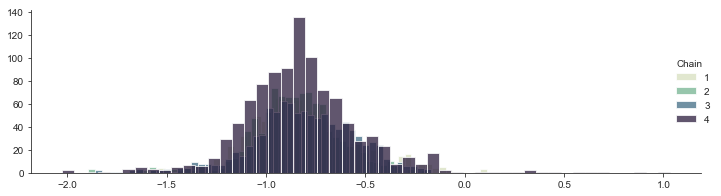

In [19]:
sp.plot_hist(trace, "gamma", 0, "");

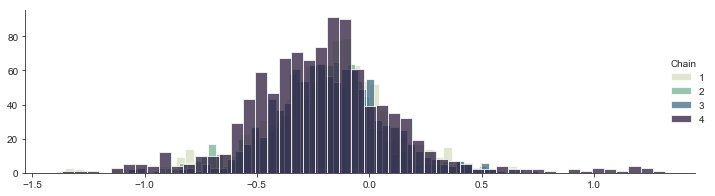

In [22]:
sp.plot_hist(trace, "gamma", 1, "");

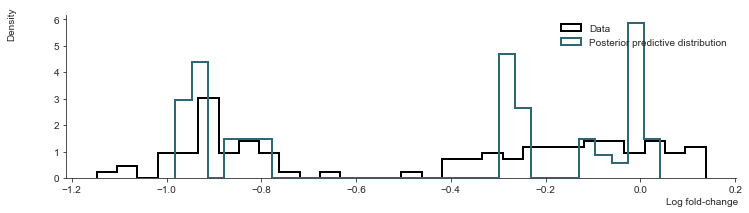

In [23]:
sp.plot_steps(readout, ppc_trace, bins=30);

In [24]:
data['gamma']

array([-0.83756546, -0.06117564])

In [20]:
numpy.mean(trace['gamma'], 0)[list(model._index_to_gene.keys())]

array([-0.83082841, -1.08141693, -1.00980663, -1.03648807, -0.96281828,
       -1.0907591 , -0.68819765, -1.13732004, -0.87623976, -0.09272733,
        0.12335033, -0.2474251 , -0.09119481, -0.02069789,  0.12871139,
       -0.09945712,  0.04327449, -0.12494691,  0.00205354,  0.0225152 ])

In [27]:
[model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]

['ACSM3',
 'ARHGAP44',
 'C2CD2L',
 'CDC123',
 'ETV2',
 'FEZF2',
 'FMO3',
 'KRT23',
 'PHOX2B',
 'POLR1B',
 'POLR2C',
 'POLR3K',
 'PSMB1',
 'PSMC1',
 'PSMC3',
 'PSMC5',
 'PSMD4',
 'SATB2',
 'TH',
 'ULBP1']

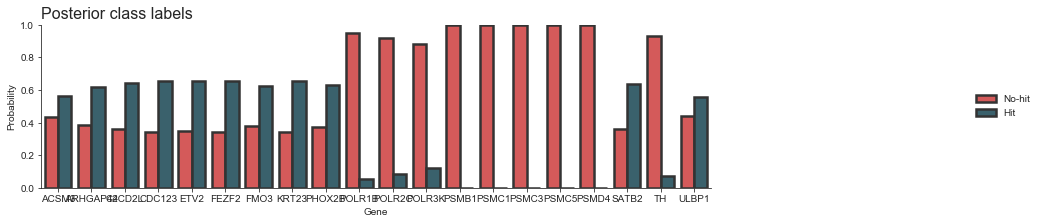

In [42]:
sp.plot_posterior_labels(trace, 
                         [model._index_to_gene[x] for x in sorted(model._index_to_gene.keys())]);

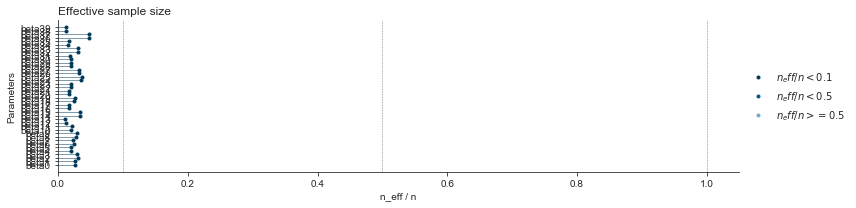

In [46]:
sp.plot_neff(trace, "beta");

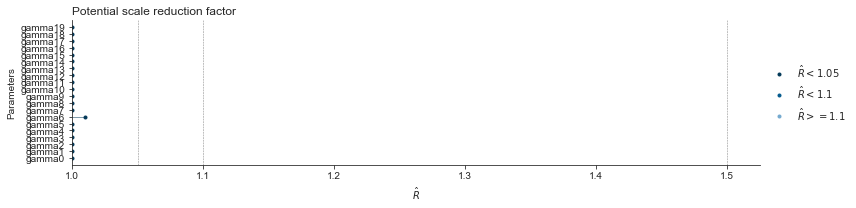

In [44]:
sp.plot_rhat(trace, "gamma");

In [56]:
np.mean((readout["readout"].values - np.mean(ppc_trace['x'], 0))**2)

0.008344435611511847